In [3]:
# Install to use the combination of pytorch and scikit-learn
!pip install skorch

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for skorch from https://files.pythonhosted.org/packages/f3/2f/2e5df7adb64d8457ea4104bcdfe4265251825d17bd3752f2de4d364723e8/skorch-1.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for tabulate>=0.7.7 from https://files.pythonhosted.org/packages/40/44/4a5f08c96eb108af5cb50b41f76142f0afa346dfa99d5296fe7202a11854/tabulate-0.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for tqdm>=4.14.0 from https://files.pythonhosted.org/packages/18/eb/fdb7eb9e48b7b02554e1664afd3bd3f117f6b6d6c5881438a0b055554f9b/tqdm-4.66.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 6.0 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 7.3 MB/s eta 0:00:00


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [68]:
df = pd.read_csv('./House_Rent_Dataset.csv')

In [55]:
print(df)

       Posted On  BHK   Rent  Size            Floor    Area Type  \
0     2022-05-18    2  10000  1100  Ground out of 2   Super Area   
1     2022-05-13    2  20000   800       1 out of 3   Super Area   
2     2022-05-16    2  17000  1000       1 out of 3   Super Area   
3     2022-07-04    2  10000   800       1 out of 2   Super Area   
4     2022-05-09    2   7500   850       1 out of 2  Carpet Area   
...          ...  ...    ...   ...              ...          ...   
4741  2022-05-18    2  15000  1000       3 out of 5  Carpet Area   
4742  2022-05-15    3  29000  2000       1 out of 4   Super Area   
4743  2022-07-10    3  35000  1750       3 out of 5  Carpet Area   
4744  2022-07-06    3  45000  1500     23 out of 34  Carpet Area   
4745  2022-05-04    2  15000  1000       4 out of 5  Carpet Area   

                 Area Locality       City Furnishing Status  Tenant Preferred  \
0                       Bandel    Kolkata       Unfurnished  Bachelors/Family   
1     Phool Bagan, Ka

In [69]:
# Oddziel target
target = pd.DataFrame(df['Rent'])
y = target
df.drop('Rent', axis=1, inplace=True)

In [57]:
# Kodowanie
for col in df[['Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']]:
    df[col] = pd.Categorical(df[col]).codes

In [58]:
# Konwersja daty
df['Posted On'] = pd.to_datetime(df['Posted On'])
df['Posted On'] = df['Posted On'].astype('int64') // 10**10

In [59]:
# Skalowanie cech numerycznych
scaler = StandardScaler()
numeric_cols = ['Posted On', 'BHK', 'Size', 'Floor', 'Bathroom']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [60]:
print(df.head())
print(target.head())

   Posted On       BHK      Size     Floor  Area Type  Area Locality  City  \
0  -0.941253 -0.100773  0.208960  1.384550          2            221     4   
1  -1.168048 -0.100773 -0.264125 -1.324614          2           1527     4   
2  -1.031971 -0.100773  0.051265 -1.324614          2           1760     4   
3   1.190623 -0.100773 -0.264125 -1.349187          2            526     4   
4  -1.349485 -0.100773 -0.185277 -1.349187          1           1890     4   

   Furnishing Status  Tenant Preferred  Bathroom  Point of Contact  
0                  2                 1  0.038594                 2  
1                  1                 1 -1.092067                 2  
2                  1                 1 -1.092067                 2  
3                  2                 1 -1.092067                 2  
4                  2                 0 -1.092067                 2  
    Rent
0  10000
1  20000
2  17000
3  10000
4   7500


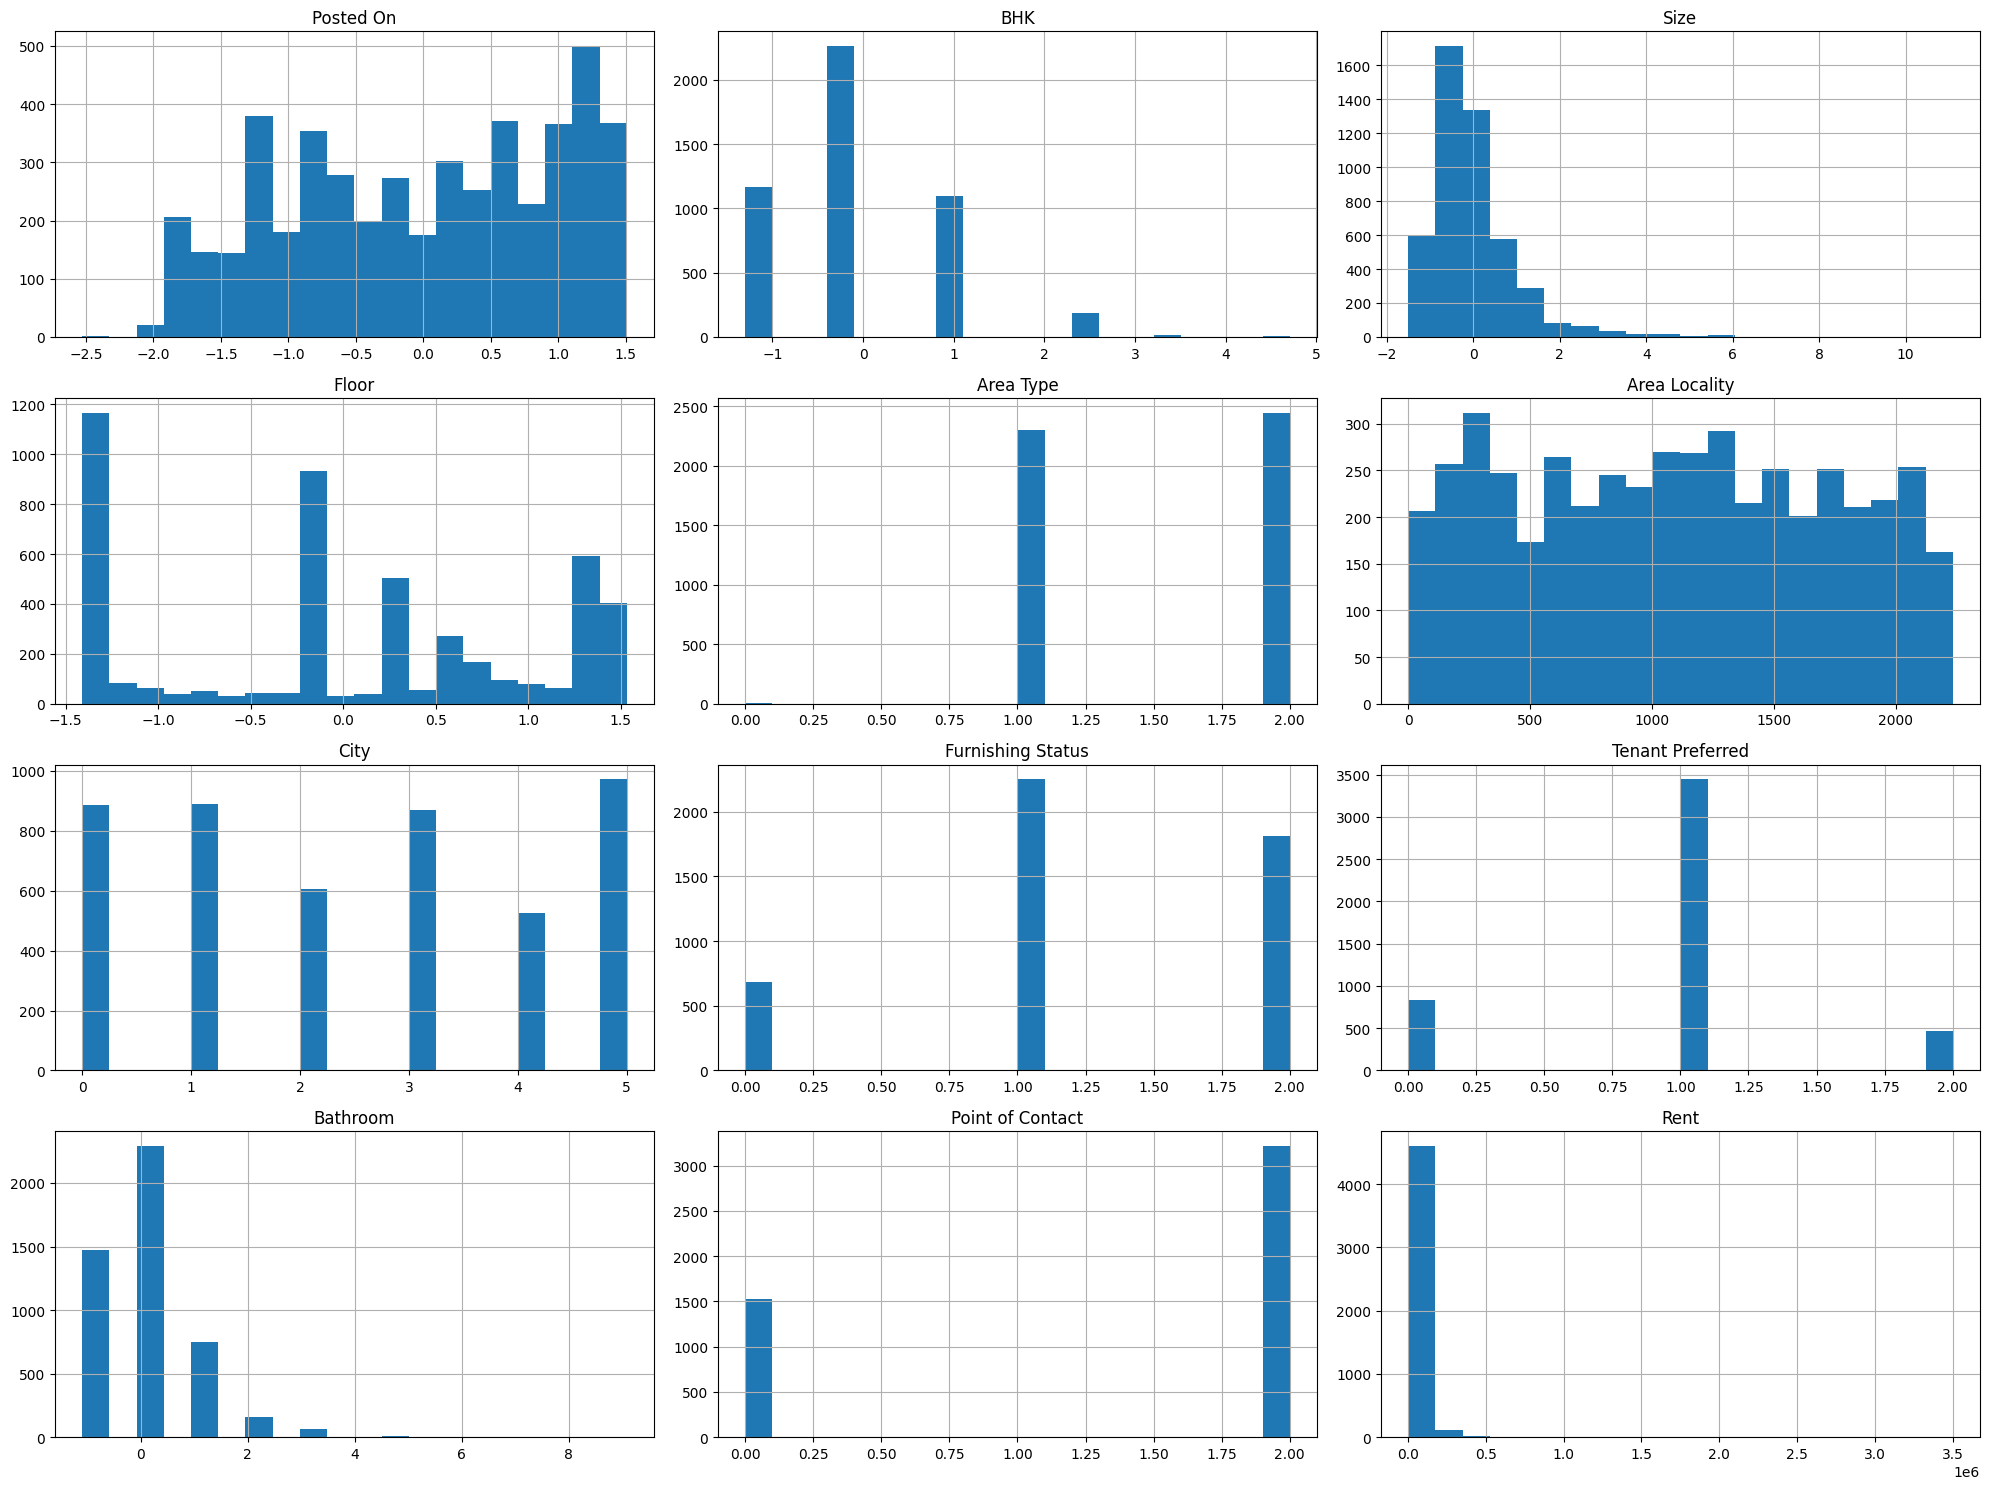

In [61]:
# Plotowanie
df_hist = df.copy()
df_hist['Rent'] = target

df_hist.hist(bins=20, figsize=(20, 15))
plt.tight_layout()
plt.show()

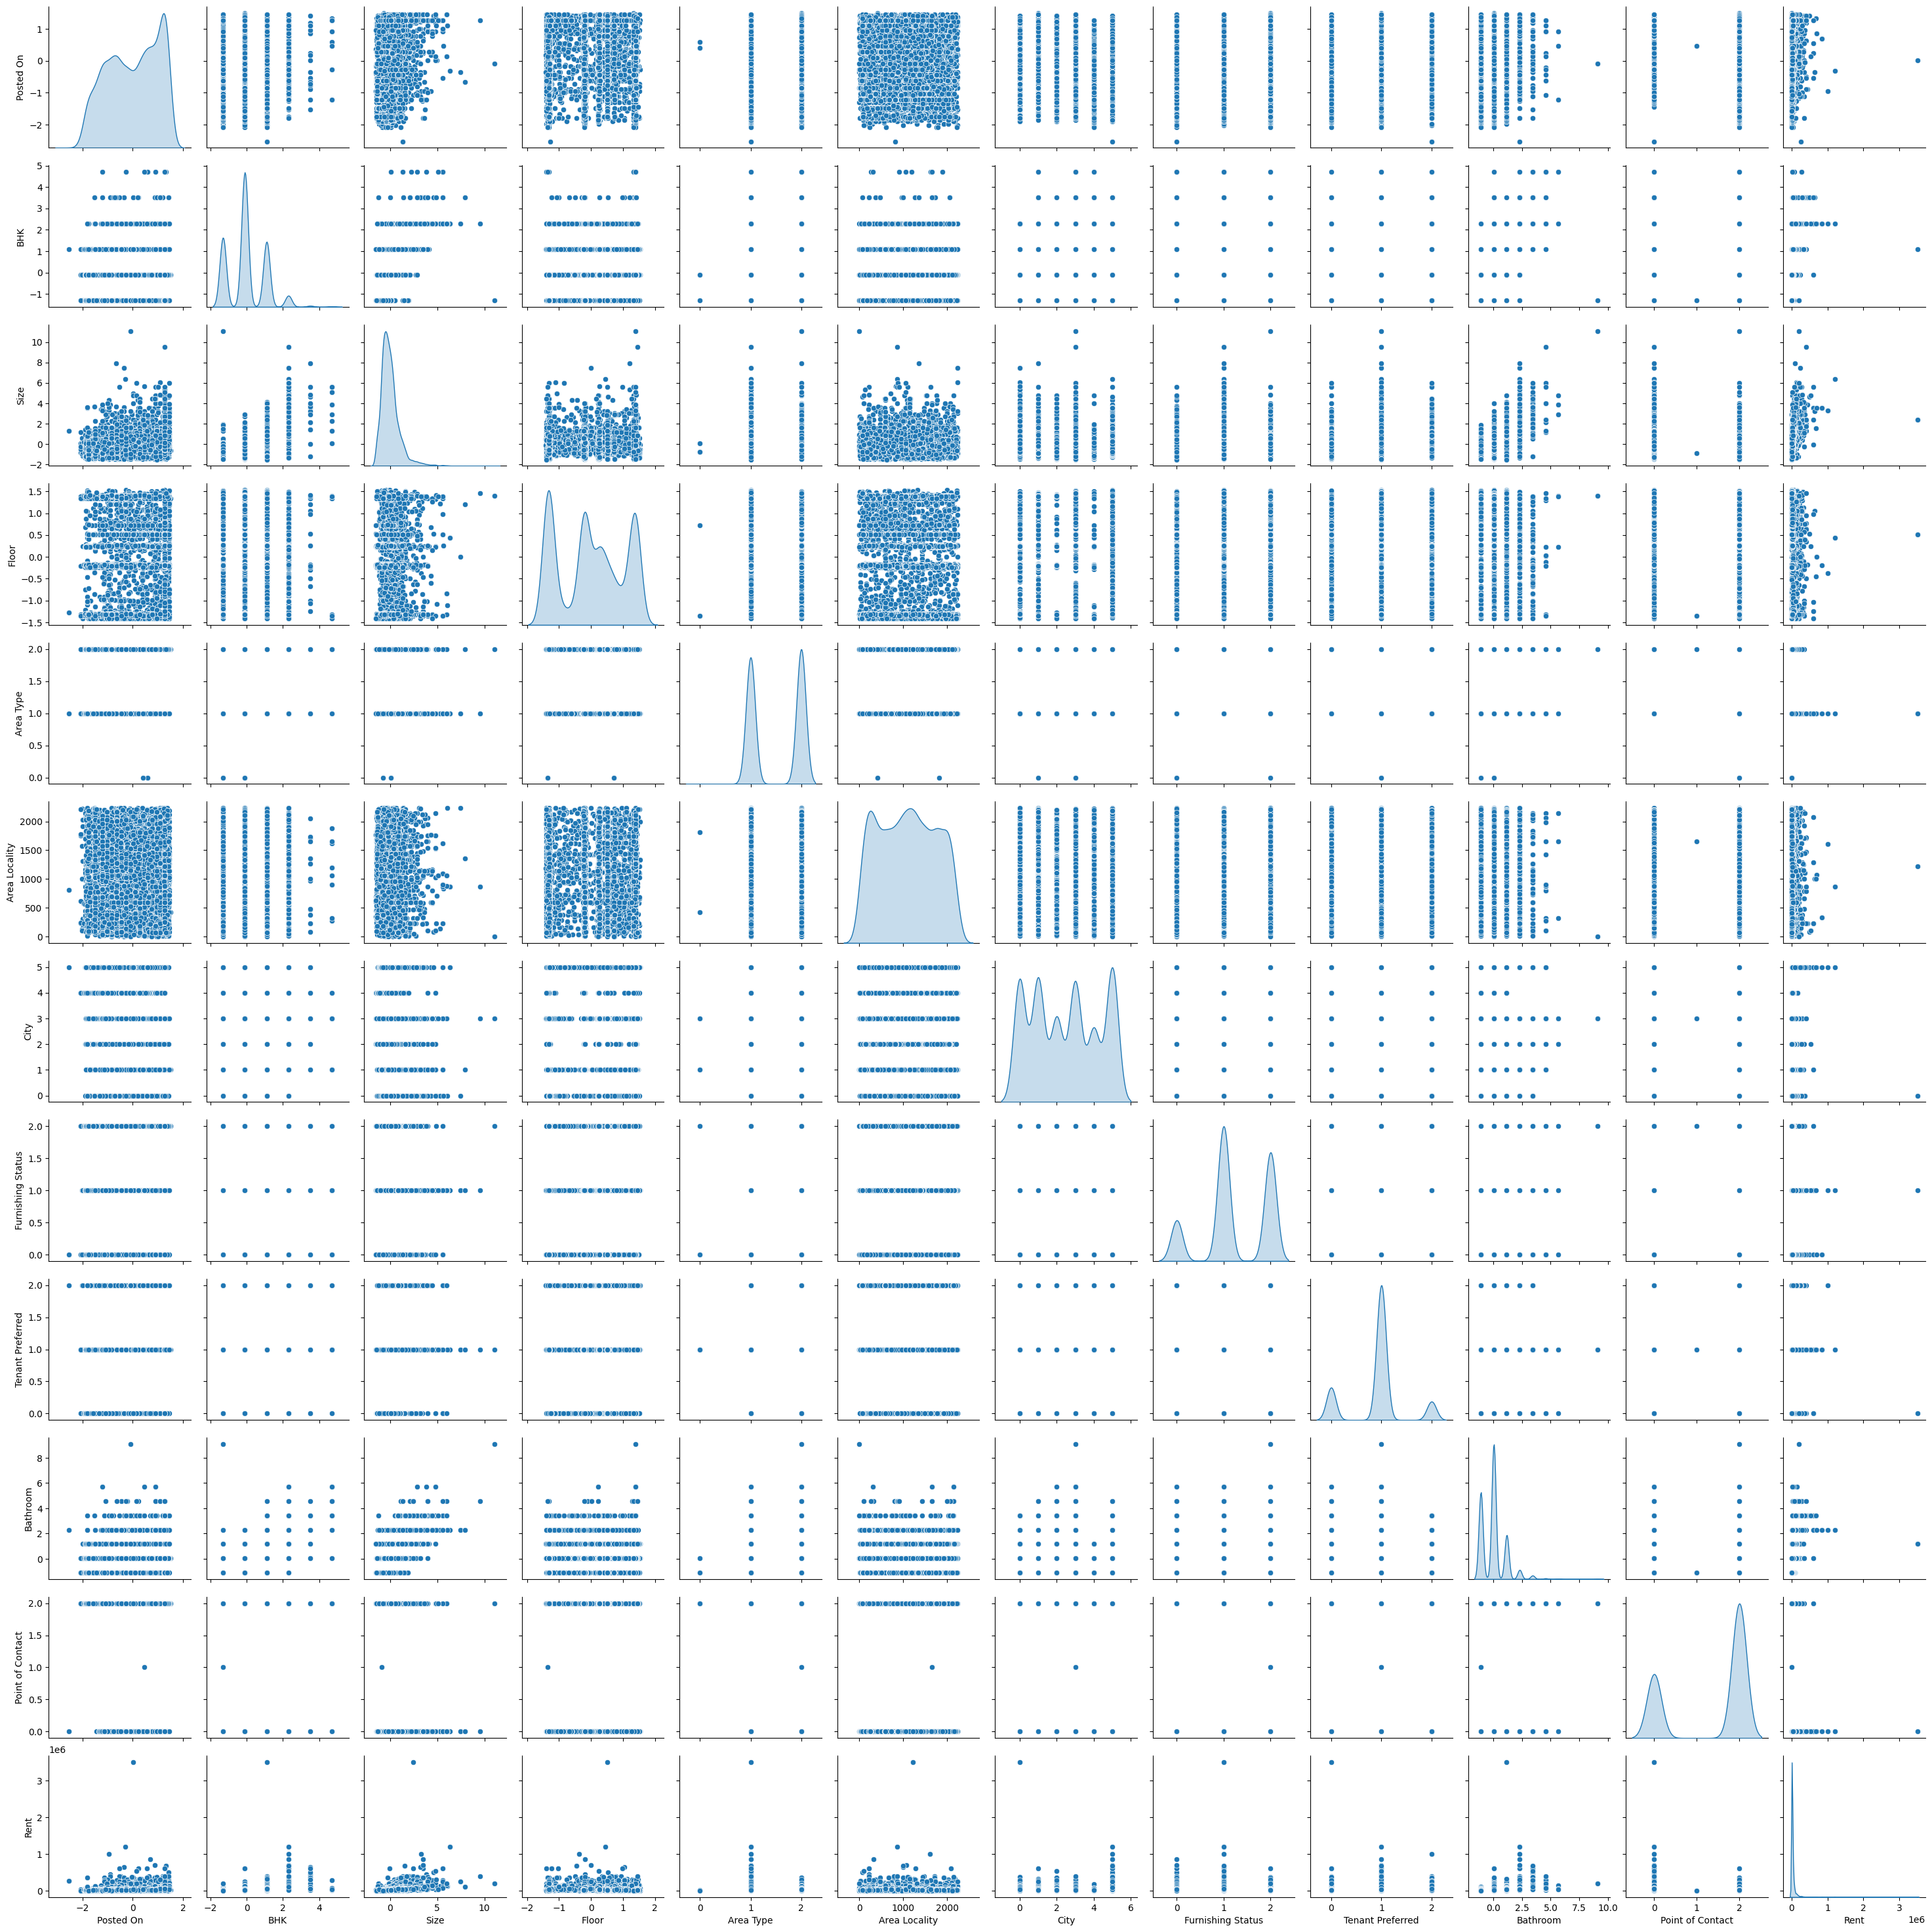

In [62]:
# Tworzenie scatterplota
sns.pairplot(df_hist, diag_kind='kde')
plt.show()

In [77]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Wczytanie danych
df = pd.read_csv('./House_Rent_Dataset.csv')

# Zakodowanie zmiennej kategorycznej 'Area Locality' za pomocą OneHotEncoder
df = pd.get_dummies(df, columns=['Area Locality'], drop_first=True)
df = pd.get_dummies(df, columns=['Area Type'], prefix='Area Type')
df = pd.get_dummies(df, columns=['Floor'], prefix='Floor')
df = pd.get_dummies(df, columns=['City'], prefix='City')
df = pd.get_dummies(df, columns=['Furnishing Status'], prefix='Furnishing Status')
df = pd.get_dummies(df, columns=['Tenant Preferred'], prefix='Tenant Preferred')
df = pd.get_dummies(df, columns=['Point of Contact'], prefix='Point of Contact')
# df = pd.get_dummies(df, columns=['Area Locality', 'Area Type', 'Floor', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact'], drop_first=True)

# Wybór zmiennych niezależnych i zależnej
X = df.drop(columns=['Rent'])
y = df['Rent']

# Podział na dane testowe i treningowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print(X_train.shape)

# Definicja modelu
model = nn.Sequential(
    nn.Linear(X_train.shape[1] - 1, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

# Definicja funkcji straty
criterion = nn.MSELoss()

# Definicja optymalizatora
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Parametry treningowe
epochs = 10
batch_size = 32

# Konwersja danych na typ float32
X_train = X_train.drop(columns=['Posted On'])
X_test = X_test.drop(columns=['Posted On'])
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Trening modelu
for epoch in range(epochs):
    running_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = torch.tensor(X_train.values[i:i+batch_size], dtype=torch.float32)
        labels = torch.tensor(y_train.values[i:i+batch_size], dtype=torch.float32)

        # Zerowanie gradientów
        optimizer.zero_grad()

        # Przewidywania modelu
        outputs = model(inputs)

        # Obliczanie straty
        loss = criterion(outputs.squeeze(), labels)

        # Propagacja wsteczna i aktualizacja wag
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Wyświetlanie straty w trakcie treningu
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(X_train)}")

(2847, 2736)
Epoch 1/10, Loss: 158296135.4857745
Epoch 2/10, Loss: 157819694.12855637
Epoch 3/10, Loss: 157082118.56410256
Epoch 4/10, Loss: 156071973.18159467
Epoch 5/10, Loss: 154795951.6347032
Epoch 6/10, Loss: 153269446.60906217
Epoch 7/10, Loss: 151513133.99367756
Epoch 8/10, Loss: 149550951.92413068
Epoch 9/10, Loss: 147408778.61046717
Epoch 10/10, Loss: 145113519.28626624


In [78]:
# Konwersja danych testowych na typ float32
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

# Ustawienie modelu w tryb ewaluacji
model.eval()

# Wyłączenie wymagania obliczania gradientów
with torch.no_grad():
    # Przewidywanie wyników na danych testowych
    inputs = torch.tensor(X_test.values, dtype=torch.float32)
    outputs = model(inputs)
    predicted_values = outputs.squeeze().numpy()

# Wyświetlenie przewidywanych wartości i rzeczywistych wartości
for predicted, actual in zip(predicted_values, y_test):
    print(f"Predicted: {predicted:.2f}, Actual: {actual:.2f}")

# Metryki oceny, takie jak średni błąd bezwzględny (MAE) lub średni błąd kwadratowy (MSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

Predicted: 5113.53, Actual: 16000.00
Predicted: 3733.47, Actual: 12000.00
Predicted: 2434.77, Actual: 28000.00
Predicted: 6962.72, Actual: 8000.00
Predicted: 10354.40, Actual: 46000.00
Predicted: 4884.57, Actual: 17000.00
Predicted: 2924.69, Actual: 57000.00
Predicted: 3272.50, Actual: 9500.00
Predicted: 11575.92, Actual: 400000.00
Predicted: 3043.95, Actual: 15000.00
Predicted: 3039.15, Actual: 10000.00
Predicted: 2352.99, Actual: 12000.00
Predicted: 4652.54, Actual: 27000.00
Predicted: 2573.51, Actual: 16000.00
Predicted: 5119.61, Actual: 15000.00
Predicted: 2574.01, Actual: 8500.00
Predicted: 12035.56, Actual: 140000.00
Predicted: 3729.44, Actual: 12000.00
Predicted: 5802.72, Actual: 6000.00
Predicted: 8574.46, Actual: 60000.00
Predicted: 5912.80, Actual: 38000.00
Predicted: 1882.51, Actual: 7500.00
Predicted: 2110.62, Actual: 23000.00
Predicted: 5574.47, Actual: 14000.00
Predicted: 13881.29, Actual: 260000.00
Predicted: 2578.97, Actual: 5000.00
Predicted: 2343.70, Actual: 6000.00
P

In [53]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression

# Utworzenie modelu regresji liniowej
model = LinearRegression()

# Konfiguracja cross-walidacji
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Ocena modelu za pomocą cross-walidacji
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

# Konwersja wyników na dodatnie wartości błędu średniokwadratowego
mse_scores = -scores

# Wyświetlenie wyników
print(f'Wyniki MSE dla każdej z fold: {mse_scores}')
print(f'Średni błąd średniokwadratowy (MSE): {np.mean(mse_scores)}')
print(f'Dewiacja standardowa MSE: {np.std(mse_scores)}')

Wyniki MSE dla każdej z fold: [1.91679549e+10 7.50599127e+10 2.18029036e+10 1.40881439e+10
 2.00397169e+10]
Średni błąd średniokwadratowy (MSE): 30031726387.2
Dewiacja standardowa MSE: 22659702980.99409


In [21]:
from sklearn.metrics import r2_score

X_train = X_train.drop(columns=['Posted On'])
X_test = X_test.drop(columns=['Posted On'])
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

model.fit(X_train, y_train)

# Predict values
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Feedforward Neural Network MSE: {mse}")
print(f"Feedforward Neural Network R2: {r2}")

Feedforward Neural Network MSE: 16656172131.335413
Feedforward Neural Network R2: -0.04697077263055216


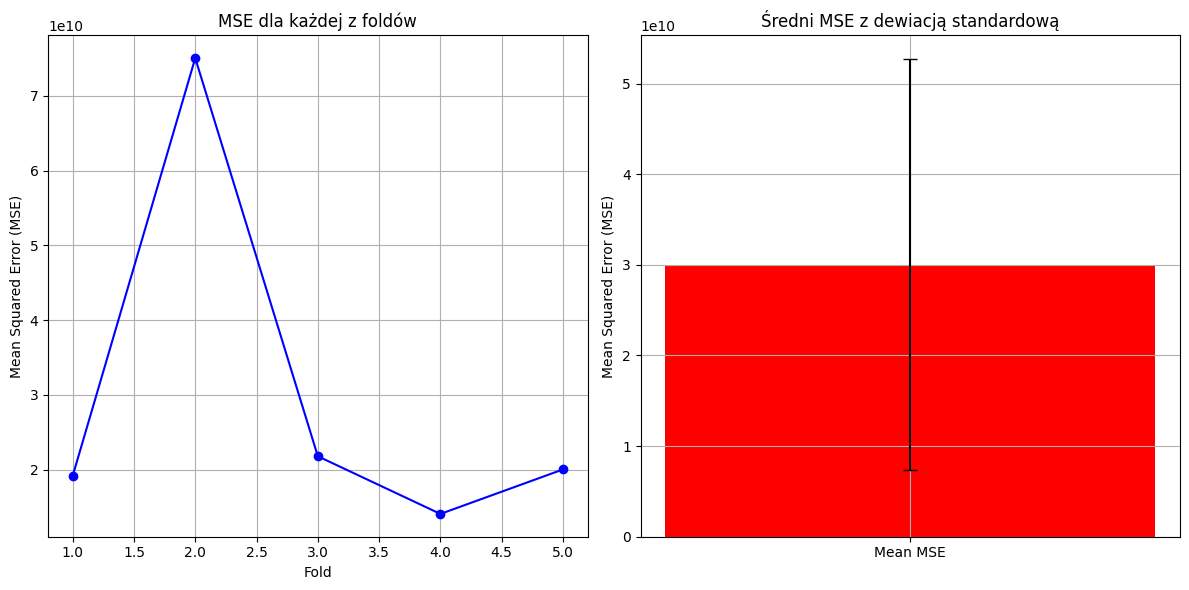

In [14]:
import matplotlib.pyplot as plt

# Tworzenie wykresu wyników cross-walidacji
plt.figure(figsize=(12, 6))

# Wykres wyników MSE dla każdej z foldów
plt.subplot(1, 2, 1)
plt.plot(range(1, len(mse_scores) + 1), mse_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE dla każdej z foldów')
plt.grid(True)

# Wykres średniego MSE z dewiacją standardową
plt.subplot(1, 2, 2)
plt.bar(['Mean MSE'], [np.mean(mse_scores)], yerr=[np.std(mse_scores)], capsize=5, color='r')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Średni MSE z dewiacją standardową')
plt.grid(True)

# Wyświetlenie wykresów
plt.tight_layout()
plt.show()

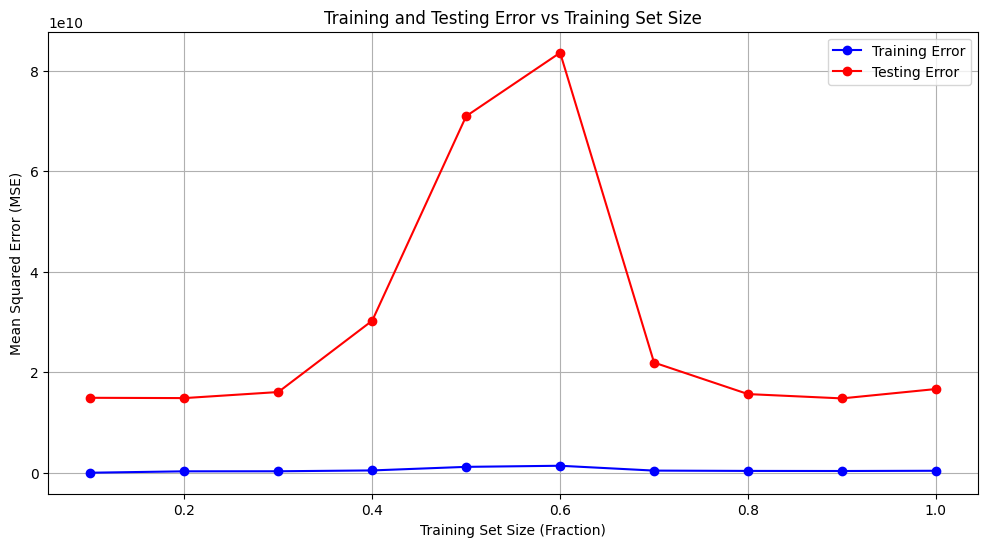

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Listy do przechowywania wyników
train_errors = []
test_errors = []
subset_sizes = np.linspace(0.1, 1.0, 10)

# Iterowanie po różnych rozmiarach podzbiorów danych treningowych
for subset_size in subset_sizes:
    # Podzbiór danych
    X_train_subset = X_train[:int(subset_size * len(X_train))]
    y_train_subset = y_train[:int(subset_size * len(y_train))]

    # Trenowanie modelu
    model = LinearRegression()
    model.fit(X_train_subset, y_train_subset)

    # Przewidywanie na zbiorze treningowym i testowym
    y_train_pred = model.predict(X_train_subset)
    y_test_pred = model.predict(X_test)

    # Obliczanie błędów MSE
    train_errors.append(mean_squared_error(y_train_subset, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

# Tworzenie wykresu
plt.figure(figsize=(12, 6))

plt.plot(subset_sizes, train_errors, 'bo-', label='Training Error')
plt.plot(subset_sizes, test_errors, 'ro-', label='Testing Error')
plt.xlabel('Training Set Size (Fraction)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Testing Error vs Training Set Size')
plt.legend()
plt.grid(True)
plt.show()


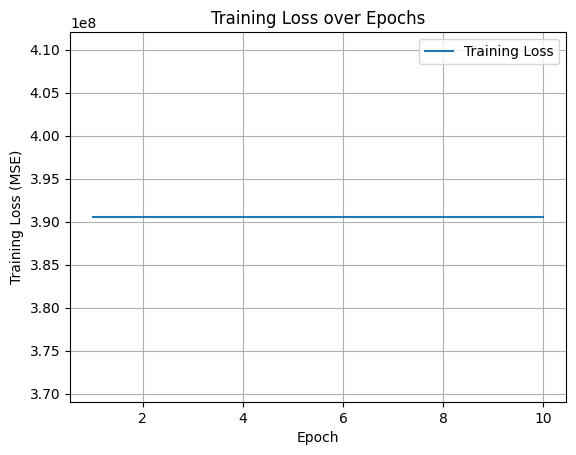

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Inicjalizacja modelu regresji
model = LinearRegression()

# Listy do przechowywania strat szkoleniowych na przestrzeni epok
train_losses = []

# Liczba epok
num_epochs = 10

# Trening modelu na przestrzeni epok
for epoch in range(num_epochs):
    # Dopasowanie modelu do danych treningowych
    model.fit(X_train, y_train)
    
    # Przewidywanie na danych treningowych
    y_train_pred = model.predict(X_train)
    
    # Obliczenie straty (MSE) dla aktualnej epoki
    train_loss = mean_squared_error(y_train, y_train_pred)
    
    # Dodanie straty do listy
    train_losses.append(train_loss)

# Tworzenie wykresu
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()